
# Win Prediction — Transformer (MoE, 2025-style) + Calibration + Explicabilité complète

Objectif : un pipeline **robuste et explicable** pour prédire la win (`R∈{-1,1}` → {0,1}), en tirant parti d'un **Transformer tabulaire séquentiel** avec **Mixture-of-Experts (Top-2)**, **calibration** (Platt), et un panel clair d'explications : **Integrated Gradients (global/local)**, **SHAP Kernel** (global), **LIME** (local), **PDP/ICE**, **attentions**.  
On trace aussi : courbes d'apprentissage, calibration, *backtest* temporel, **prédictions historiques vs réelles**, et **20 scénarios futurs** exportés.

> Conçu pour tourner en CPU ; décommentez les installations si nécessaire.


## (Optionnel) Installations

In [365]:

# %pip install -q pandas numpy scikit-learn matplotlib torch shap lime


## Imports & configuration

In [366]:
import os, math, json, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss, brier_score_loss, accuracy_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
import torch
import torch.nn as nn
import torch.nn.functional as _F
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")
np.random.seed(42); random.seed(42); torch.manual_seed(42)
DEVICE = torch.device("cpu")
print("Torch device:", DEVICE)

# ==========================================================
# 1) Calibration (Platt) & helpers
# ==========================================================

class PlattCalibrator:
    def __init__(self):
        self.a = None
        self.b = None
        self.fitted = False
    def fit(self, z_val: np.ndarray, y_val: np.ndarray, max_iter: int = 200):
        ab = torch.nn.Parameter(torch.tensor([1.0, 0.0], dtype=torch.float32))
        opt = torch.optim.LBFGS([ab], lr=0.5, max_iter=max_iter, line_search_fn="strong_wolfe")
        zv = torch.tensor(z_val, dtype=torch.float32).view(-1,1)
        yv = torch.tensor(y_val, dtype=torch.float32).view(-1,1)
        def nll():
            opt.zero_grad()
            a_, b_ = ab[0], ab[1]
            p = torch.sigmoid(a_*zv + b_)
            loss = _F.binary_cross_entropy(p, yv)
            loss.backward(); return loss
        opt.step(nll)
        self.a, self.b = [float(v) for v in ab.detach().cpu().numpy().tolist()]
        self.fitted = True
    def transform_logits(self, z: np.ndarray) -> np.ndarray:
        if not self.fitted or self.a is None or self.b is None:
            return 1.0 / (1.0 + np.exp(-z))
        return 1.0 / (1.0 + np.exp(-(self.a*z + self.b)))

CAL = PlattCalibrator()

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

Torch device: cpu


## Chargement des données (Google Sheet + fallback CSV)

In [367]:

SHEET_ID = "1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y"
GID = "1517184233"
DATA_PATH = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={GID}"
print("Data path:", DATA_PATH)

def load_df():
    try:
        df = pd.read_csv(DATA_PATH).dropna(axis=1, how="all")
        print("Loaded from Google Sheet")
        return df
    except Exception as e:
        print("Google Sheet failed, fallback:", e)
        raise


Data path: https://docs.google.com/spreadsheets/d/1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y/export?format=csv&gid=1517184233


## Feature engineering cohérent avec ton cadre

In [368]:
# Pickers tolérants aux noms
CANDS = {
    "label": ["R", "result", "win", "label", "target"],
    "gap":   ["Team Gap Early", "team gap early", "team_diff", "team_gap", "teamgap"],
    "rel":   ["Perf relative", "relative_perf", "rel_perf", "perf_relative", "relative"],
    "intr":  ["Perf intrinsèque", "intrinsic_perf", "intrinsic_skill", "perf_intrinseque", "intrinsic"],
    "time":  ["timestamp", "time", "date", "match_time"],
}

def pick_name(df, keys):
    cols = list(df.columns)
    # match exact
    for k in keys:
        for c in cols:
            if c.lower().strip() == k.lower().strip():
                return c
    # match substring
    for k in keys:
        for c in cols:
            if k.lower().strip() in c.lower().strip():
                return c
    return None

# cleaning numérique robuste

def coerce_numeric_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace(",", ".", regex=False)
    s = s.str.extract(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)", expand=False)
    s = pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan)
    if s.notna().sum() > 0:
        lo = np.nanpercentile(s, 1)
        hi = np.nanpercentile(s, 99)
        s = s.clip(lo, hi)
    s = s.ffill().bfill()
    if s.isna().any():
        med = float(np.nanmedian(s.values)) if np.isfinite(np.nanmedian(s.values)) else 0.0
        s = s.fillna(med)
    return s.astype(np.float32)


def clean_numeric(df: pd.DataFrame, cols):
    df = df.copy()
    for c in cols:
        df[c] = coerce_numeric_series(df[c])
    return df

# Charge & featurise

df = load_df().replace({"-": np.nan})
print("Shape raw:", df.shape)

label_col = pick_name(df, CANDS["label"])  # requis
gap_col   = pick_name(df, CANDS["gap"])    # requis
rel_col   = pick_name(df, CANDS["rel"])    # optionnel
intr_col  = pick_name(df, CANDS["intr"])   # optionnel

assert label_col and gap_col, "Colonnes R et Team Gap Early requises dans la feuille."

# types & normalisations de base
for c in [label_col, gap_col] + ([rel_col] if rel_col else []) + ([intr_col] if intr_col else []):
    if c is not None and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# {−1,1}→{0,1}
df = df.dropna(subset=[label_col, gap_col]).copy()
df[label_col] = df[label_col].map({-1:0, 1:1}).fillna(df[label_col]).astype(int)

# bornage gap
df[gap_col] = df[gap_col].clip(-2, 2).fillna(0.0)

# perf relative
if rel_col is None:
    rel_col = "Perf relative (fallback)"
    df[rel_col] = 0.0
else:
    df[rel_col] = df[rel_col].fillna(0.0)

# intrinsic skill (fallback = EMA de rel)
if intr_col and intr_col in df.columns:
    df["intrinsic_skill"] = pd.to_numeric(df[intr_col], errors="coerce").fillna(0.0)
else:
    s = df[rel_col].fillna(0.0)
    df["intrinsic_skill"] = s.ewm(alpha=0.2, adjust=False).mean().shift(1).fillna(float(s.median()))

# lose_streak sur gap négatif
streak = 0; buf = []
for g in df[gap_col].values:
    if g < 0: streak += 1
    else: streak = 0
    buf.append(streak)
df["lose_streak"] = buf

# interactions dérivées
df["gap_x_rel"] = df[gap_col] * df[rel_col]
df["rel_sq"]    = df[rel_col]**2
df["skill_sq"]  = df["intrinsic_skill"]**2

FEATURES = [gap_col, rel_col, "intrinsic_skill", "lose_streak", "gap_x_rel", "rel_sq", "skill_sq"]

# nettoyage ciblé
df = clean_numeric(df, FEATURES)
# reconstruct dérivées (sécurité)
df["gap_x_rel"] = df[gap_col] * df[rel_col]
df["rel_sq"]    = df[rel_col]**2
df["skill_sq"]  = df["intrinsic_skill"]**2

assert np.isfinite(df[FEATURES].values).all(), "Non‑finies détectées après nettoyage."

print("Features:", FEATURES)

# Option: colonne d’ancrage externe pour gap_next
PRED_GAP_COL = None
for c in df.columns:
    if "pred_teamgap" in c.lower() or "pred_teamgapearly_next" in c.lower():
        PRED_GAP_COL = c
        df[PRED_GAP_COL] = pd.to_numeric(
            df[PRED_GAP_COL].astype(str).str.replace(",", ".", regex=False),
            errors="coerce"
        )
        break

Loaded from Google Sheet
Shape raw: (107, 8)
Features: ['Team Gap Early', 'Perf relative', 'intrinsic_skill', 'lose_streak', 'gap_x_rel', 'rel_sq', 'skill_sq']


## Construction séquentielle (fenêtrage)

In [ ]:
WIN = 5
vals = df[FEATURES].values.astype(np.float32)
labs = df[label_col].values.astype(np.int64)
N_raw = len(df)

X_all, y_all, t_idx, Yf_all = [], [], [], []
for i in range(WIN, N_raw):
    X_all.append(vals[i-WIN:i, :])
    y_all.append(labs[i])
    Yf_all.append(vals[i, :])
    t_idx.append(i)

if len(X_all) == 0:
    raise ValueError(f"Aucune séquence. Baissez WIN (actuel={WIN}) ou augmentez les données.")

X_all = np.stack(X_all, axis=0).astype(np.float32)  # (N,WIN,F)
y_all = np.asarray(y_all, dtype=np.int64)
Yf_all = np.stack(Yf_all, axis=0).astype(np.float32)
t_idx = np.asarray(t_idx, dtype=int)

cut  = int(0.70 * N_raw)
cut2 = int(0.85 * N_raw)
purge = WIN
mask_tr = t_idx < (cut - purge)
mask_va = (t_idx >= cut) & (t_idx < (cut2 - purge))
mask_te = t_idx >= cut2


Xtr, ytr, Yf_tr = X_all[mask_tr], y_all[mask_tr], Yf_all[mask_tr]
Xva, yva, Yf_va = X_all[mask_va], y_all[mask_va], Yf_all[mask_va]
Xte, yte, Yf_te = X_all[mask_te], y_all[mask_te], Yf_all[mask_te]

# Garantis val/test non vides (si dataset très court)

def siphon_from_train(X, y, take_ratio=0.15, min_take=1):
    if len(X) <= 1:
        return X, y, X[:0], y[:0]
    take = max(min_take, int(take_ratio*len(X)))
    take = min(take, len(X)-1)
    return (X[:-take], y[:-take], X[-take:], y[-take:])

if Xva.shape[0] == 0 and Xtr.shape[0] >= 2:
    Xtr, ytr, Xva, yva = siphon_from_train(Xtr, ytr, 0.15)
    print(f"Val vide → prélèvement {len(Xva)} séq depuis la fin du train.")
if Xte.shape[0] == 0 and Xtr.shape[0] >= 2:
    Xtr, ytr, Xte, yte = siphon_from_train(Xtr, ytr, 0.15)
    print(f"Test vide → prélèvement {len(Xte)} séq depuis la fin du train.")

# Scaling 3D par feature
scalers: list[StandardScaler] = []
for j in range(len(FEATURES)):
    sc = StandardScaler()
    sc.fit(Xtr[:, :, j].reshape(-1,1))
    scalers.append(sc)

def transform3d(X, scalers):
    if X.ndim != 3 or X.shape[0] == 0:
        return X
    N,T,F_ = X.shape
    Z = X.copy()
    for j, sc in enumerate(scalers):
        col = Z[:, :, j].reshape(-1,1)
        col = sc.transform(col)
        col = np.nan_to_num(col, nan=0.0, posinf=0.0, neginf=0.0)
        Z[:, :, j] = col.reshape(N,T)
    if not np.isfinite(Z).all():
        raise ValueError("Après scaling: valeurs non finies detected.")
    return Z.astype(np.float32)


def transform2d(Y, scalers):
    if Y.ndim != 2 or Y.shape[0] == 0:
        return Y
    Z = Y.copy()
    for j, sc in enumerate(scalers):
        Z[:, j] = sc.transform(Z[:, j].reshape(-1,1)).ravel()
    Z = np.nan_to_num(Z, nan=0.0, posinf=0.0, neginf=0.0)
    return Z.astype(np.float32)

Xtrn, Xvan, Xten = transform3d(Xtr, scalers), transform3d(Xva, scalers), transform3d(Xte, scalers)
Yf_trn, Yf_van, Yf_ten = transform2d(Yf_tr, scalers), transform2d(Yf_va, scalers), transform2d(Yf_te, scalers)

print("Seq shapes (scaled)", Xtrn.shape, Xvan.shape, Xten.shape, "| y mean:", (ytr.mean() if ytr.size else np.nan))


Seq shapes (scaled) (31, 7, 7) (3, 7, 7) (10, 7, 7) | y mean: 0.5806451612903226


## Modèle Transformer Tabulaire séquentiel + MoE (Top-2)

In [370]:
class ExpertMLP(nn.Module):
    def __init__(self, d, h):
        super().__init__()
        self.fc1 = nn.Linear(d, h)
        self.fc2 = nn.Linear(h, d)
    def forward(self, x):
        return self.fc2(_F.silu(self.fc1(x)))

class Top1GumbelMoE(nn.Module):
    def __init__(self, d_model, n_experts=4, hidden=64, tau_start=2.0, tau_end=0.5, anneal_epochs=200):
        super().__init__()
        self.experts = nn.ModuleList([ExpertMLP(d_model, hidden) for _ in range(n_experts)])
        self.gate = nn.Linear(d_model, n_experts)
        self.n_experts = n_experts
        self.tau_start, self.tau_end, self.anneal_epochs = float(tau_start), float(tau_end), float(anneal_epochs)
        self.register_buffer("t", torch.tensor(0.))
    def temperature(self):
        p = torch.clamp(self.t / max(1.0, self.anneal_epochs), 0, 1)
        return self.tau_start*(1-p) + self.tau_end*p
    def forward(self, x):  # x:[B,T,D]
        logits = self.gate(x)
        tau = max(float(self.temperature()), 1e-3)
        u = torch.rand_like(logits).clamp_(1e-6, 1-1e-6)
        gumbel = -torch.log(-torch.log(u))
        w_soft = _F.softmax((logits + gumbel) / tau, dim=-1)
        hard_idx = w_soft.argmax(dim=-1)
        one_hot = _F.one_hot(hard_idx, num_classes=self.n_experts).float()
        w_st = one_hot - w_soft.detach() + w_soft  # straight-through
        Ys = torch.stack([exp(x) for exp in self.experts], dim=-2)  # [B,T,E,D]
        out = (w_st.unsqueeze(-1) * Ys).sum(dim=-2)
        out = torch.nan_to_num(out, nan=0.0, posinf=0.0, neginf=0.0)
        aux = w_soft.mean(dim=(0,1))  # usage moyen experts [E]
        return out, aux

class BlockGumbel(nn.Module):
    def __init__(self, d_model, nhead, n_experts=4, moe_hidden=64, p=0.1, p_attn=0.0):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, nhead, batch_first=True, dropout=p_attn)
        self.ln1 = nn.LayerNorm(d_model)
        self.moe = Top1GumbelMoE(d_model, n_experts=n_experts, hidden=moe_hidden)
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(p)
    def forward(self, x, attn_mask=None):
        h, w = self.attn(x, x, x, attn_mask=attn_mask, need_weights=True)
        x = self.ln1(x + self.drop(h))
        y, aux = self.moe(x)
        x = self.ln2(x + self.drop(y))
        return x, w, aux


def _init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class AddPositional(nn.Module):
    def __init__(self, d_model, T):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, T, d_model))
        nn.init.trunc_normal_(self.pe, std=0.02)
    def forward(self, x):  # x: [B,T,D]
        return x + self.pe

class MLP(nn.Module):
    def __init__(self, d_in, d_hidden, d_out, p=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden), nn.SiLU(), nn.Dropout(p),
            nn.Linear(d_hidden, d_hidden), nn.SiLU(), nn.Dropout(p),
            nn.Linear(d_hidden, d_out)
        )
    def forward(self, x):
        return self.net(x)

class TabTransformerMoE_MultiFlow(nn.Module):
    def __init__(self, d_in, d_model=128, depth=3, nhead=8, n_experts=8, moe_hidden=256,
                 p=0.25, p_attn=0.15, feat_dim=7):
        super().__init__()
        self.proj = nn.Linear(d_in, d_model)
        self.pos = AddPositional(d_model, T=WIN)
        self.blocks = nn.ModuleList([
            BlockGumbel(d_model, nhead, n_experts, moe_hidden, p, p_attn) for _ in range(depth)
        ])
        # Heads
        self.head_cls = nn.Linear(d_model, 1)                       # (a) proba win
        self.head_next_b = MLP(d_model + feat_dim, 256, feat_dim)   # (b) next features (sans p)
        self.head_next_c = MLP(d_model + feat_dim + 1, 256, feat_dim) # (c) next features (avec p)
        self.apply(_init_weights)
    def encode(self, x):  # x:[B,T,F]
        z = self.proj(x)
        z = self.pos(z)
        attn_ws, auxs = [], []
        for blk in self.blocks:
            z, w, aux = blk(z, attn_mask=None)
            attn_ws.append(w); auxs.append(aux)
        h = z.mean(dim=1)  # pooled
        return h, attn_ws, auxs
    def forward(self, x, use_p_stopgrad=True):
        B,T,F_ = x.shape
        h, attn_ws, auxs = self.encode(x)
        x_last = x[:, -1, :]
        logit_a = self.head_cls(h).squeeze(-1)
        p_a = torch.sigmoid(logit_a).unsqueeze(-1)
        x_next_b = self.head_next_b(torch.cat([h, x_last], dim=-1))
        p_in = p_a.detach() if use_p_stopgrad else p_a
        x_next_c = self.head_next_c(torch.cat([h, x_last, p_in], dim=-1))
        return logit_a, x_next_b, x_next_c, attn_ws, auxs
    def classify_on_seq(self, x_seq):
        h, _, _ = self.encode(x_seq)
        return self.head_cls(h).squeeze(-1)

## Entraînement : AdamW + early stopping (logloss) + OneCycleLR

Train/Val shapes: (31, 7, 7) (3, 7, 7) | y: (31,) (3,)
[init] val_loss=1.6180 | steps/epoch=8
[ep 001] train=1.5430  val=1.9599
[ep 005] train=1.4366  val=1.8628
[ep 010] train=1.3374  val=2.0390
[ep 015] train=1.3378  val=2.1463
[ep 020] train=1.3352  val=2.3805
[ep 025] train=1.2485  val=2.4853
[ep 030] train=1.1885  val=2.5744
[ep 035] train=1.3748  val=2.0172
[ep 040] train=1.2859  val=2.5604
[ep 045] train=1.1934  val=2.2887
[ep 050] train=1.5007  val=2.1597
[ep 055] train=1.3144  val=2.1907
[ep 060] train=1.1483  val=2.3655
[ep 065] train=1.5570  val=2.3935
[ep 070] train=1.2677  val=2.1641
[ep 075] train=1.2757  val=1.9677
[ep 080] train=1.3044  val=2.4493
[ep 085] train=1.4093  val=2.1927
[ep 090] train=1.4992  val=2.2228
[ep 095] train=1.3408  val=2.6507
[ep 100] train=1.1937  val=2.7761
[ep 105] train=1.1975  val=2.3251
[ep 110] train=1.4698  val=2.3358
[ep 115] train=1.2812  val=2.5245
[ep 120] train=1.1837  val=2.8417
[ep 125] train=1.1700  val=2.1724
[ep 130] train=1.1791 

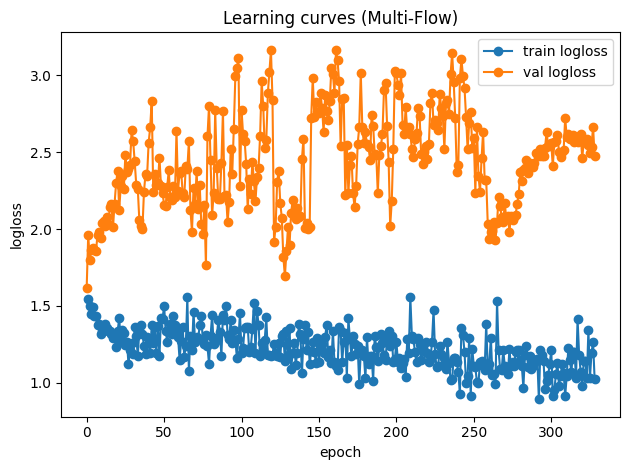

In [ ]:

class MultiFlowDS(Dataset):
    def __init__(self, X, y, yfeat_next):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.yf = torch.tensor(yfeat_next, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i], self.yf[i]

smoothL1 = nn.SmoothL1Loss()
bce = nn.BCEWithLogitsLoss()

def kldiv_probs(p, q, eps=1e-6):
    p = p.clamp(eps, 1.0-eps); q = q.clamp(eps, 1.0-eps)
    return (p*torch.log(p/q) + (1-p)*torch.log((1-p)/(1-q))).mean()

def sanitize(x):
    return torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

def train_model_multiflow(
    Xtr, ytr, Yf_tr, Xva, yva, Yf_va,
    epochs=140, bs=16, lr=2e-3, wd=2e-3, patience=30,
    d_model=128, depth=3, nhead=8, n_experts=8, moe_hidden=256,
    p=0.35, p_attn=0.25, lambda_aux=0.10, grad_clip=0.5,
    # NEW ↓
    mixup_alpha=0.3, time_mask_prob=0.5, time_mask_frac=0.3,
    feature_drop_p=0.20, input_noise_std=0.02,
    label_smoothing=0.07, balance_pos_weight=True,
    scheduler="auto", warmup_epochs=5,
    use_p_stopgrad=True, log_every=5,
    swa=False, swa_start_epoch=None
):
    if isinstance(bs, str) and bs.lower() == "auto":
        bs = auto_bs(len(Xtr))

    tr_dl = DataLoader(MultiFlowDS(Xtr,ytr,Yf_tr), batch_size=bs, shuffle=True)
    va_dl = DataLoader(MultiFlowDS(Xva,yva,Yf_va), batch_size=bs, shuffle=False)

    model = TabTransformerMoE_MultiFlow(
        d_in=Xtr.shape[-1], d_model=d_model, depth=depth, nhead=nhead,
        n_experts=n_experts, moe_hidden=moe_hidden, p=p, p_attn=p_attn,
        feat_dim=Xtr.shape[-1]
    ).to(DEVICE)

    # --- BCE: balance + label smoothing
    pos_rate = float(ytr.mean()) if len(ytr) else 0.5
    pos_w = None
    if balance_pos_weight and 0.0 < pos_rate < 1.0:
        pos_w = torch.tensor([(1.0-pos_rate)/max(pos_rate,1e-6)], device=DEVICE)
    def bce_sm(logits, y):
        if label_smoothing > 0:
            y = y*(1.0-label_smoothing) + 0.5*label_smoothing
        return _F.binary_cross_entropy_with_logits(logits, y, pos_weight=pos_w)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    steps_per_epoch = max(1, len(tr_dl))
    if scheduler == "auto":
        if steps_per_epoch < 8:
            # warmup + cosine si peu de steps
            def lr_lambda(e):
                if e < warmup_epochs:
                    return (e+1)/warmup_epochs
                progress = (e - warmup_epochs) / max(1, (epochs - warmup_epochs))
                return 0.5*(1+math.cos(math.pi*progress))
            sch = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
        else:
            sch = torch.optim.lr_scheduler.OneCycleLR(
                opt, max_lr=lr, steps_per_epoch=steps_per_epoch, epochs=epochs
            )
    else:
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max(1,epochs-warmup_epochs))
    
    is_onecycle = isinstance(sch, torch.optim.lr_scheduler.OneCycleLR)

    # (optionnel) SWA
    if swa:
        from torch.optim.swa_utils import AveragedModel, SWALR
        swa_model = AveragedModel(model)
        swa_start_epoch = swa_start_epoch or int(0.7*epochs)
        swa_sch = SWALR(opt, swa_lr=lr*0.5)

    def time_mask(x):
        if time_mask_prob<=0 or np.random.rand()>time_mask_prob: return x
        B,T,D = x.shape; L = max(1, int(T*time_mask_frac))
        s = np.random.randint(0, T-L+1); x2 = x.clone(); x2[:, s:s+L, :] = 0.0
        return x2

    def apply_feature_drop_and_noise(x):
        if feature_drop_p > 0:
            drop = (torch.rand(1,1,x.size(-1), device=x.device) < feature_drop_p).float()
            x = x * (1.0 - drop)
        if input_noise_std > 0:
            x = x + torch.randn_like(x) * input_noise_std
        return x

    def do_mixup(x, y):
        if mixup_alpha <= 0: return x, y
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        idx = torch.randperm(x.size(0), device=x.device)
        return lam*x + (1-lam)*x[idx], lam*y + (1-lam)*y[idx]

    def moe_balance_kl(aux_list):
        loss=0.0
        for aux in aux_list:
            p = (aux / (aux.sum()+1e-9)).clamp_min(1e-9)
            u = torch.full_like(p, 1.0/len(p))
            loss += torch.sum(p*(p.log()-u.log()))
        return loss / max(1,len(aux_list))

    best=float("inf"); bad=0; best_state=None
    hist={"train_ll":[], "val_ll":[]}

    # epoch 0 val
    model.eval(); s=0.0; n=0
    with torch.no_grad():
        for xb,yb,yf in va_dl:
            xb=xb.to(DEVICE); yb=yb.to(DEVICE).view(-1); yf=yf.to(DEVICE)
            logit_a, x_b, x_c, _, auxs = model(xb, use_p_stopgrad=True)
            La = bce_sm(logit_a, yb); Lb = smoothL1(x_b, yf); Lc = smoothL1(x_c, yf)
            Lcons = _F.mse_loss(x_b, x_c); loss = La + 0.5*Lb + 0.7*Lc + 0.2*Lcons + lambda_aux*moe_balance_kl(auxs)
            s += loss.item()*xb.size(0); n += xb.size(0)
    hist["train_ll"].append(np.nan); hist["val_ll"].append(s/max(1,n))
    print(f"[init] val_loss={hist['val_ll'][-1]:.4f} | steps/epoch={steps_per_epoch}")

    for ep in range(1, epochs+1):
        for blk in model.blocks:
            blk.moe.t += 0.5  # anneal plus lent du gumbel

        model.train(); s=0.0; n=0
        for xb,yb,yf in tr_dl:
            xb=xb.to(DEVICE); yb=yb.to(DEVICE).view(-1); yf=yf.to(DEVICE)
            xb = time_mask(xb); xb, yb = do_mixup(xb, yb); xb = apply_feature_drop_and_noise(xb)
            xb = torch.nan_to_num(xb)

            logit_a, x_b, x_c, _, auxs = model(xb, use_p_stopgrad=use_p_stopgrad)
            La = bce_sm(logit_a, yb)
            Lb = smoothL1(x_b, yf); Lc = smoothL1(x_c, yf)
            Lcons = _F.mse_loss(x_b, x_c)
            x_aug = torch.cat([xb[:,1:,:], x_c.unsqueeze(1)], dim=1)
            logit_d = model.classify_on_seq(x_aug)
            Ld = bce_sm(logit_d, yb)

            loss = 1.0*La + 0.5*Lb + 0.7*Lc + 0.2*Lcons + 0.5*Ld + lambda_aux*moe_balance_kl(auxs)

            opt.zero_grad(); loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()
            if is_onecycle:
                sch.step()

            s += loss.item()*xb.size(0); n += xb.size(0)

        train_ll = s/max(1,n)

        # val
        model.eval(); sv=0.0; nv=0
        with torch.no_grad():
            for xb,yb,yf in va_dl:
                xb=xb.to(DEVICE); yb=yb.to(DEVICE).view(-1); yf=yf.to(DEVICE)
                xb = torch.nan_to_num(xb)
                logit_a, x_b, x_c, _, auxs = model(xb, use_p_stopgrad=True)
                La = bce_sm(logit_a, yb)
                Lb = smoothL1(x_b, yf); Lc = smoothL1(x_c, yf)
                Lcons = _F.mse_loss(x_b, x_c)
                x_aug = torch.cat([xb[:,1:,:], x_c.unsqueeze(1)], dim=1)
                logit_d = model.classify_on_seq(x_aug)
                Ld = bce_sm(logit_d, yb)
                sv += (1.0*La + 0.5*Lb + 0.7*Lc + 0.2*Lcons + 0.5*Ld + lambda_aux*moe_balance_kl(auxs)).item()*xb.size(0)
                nv += xb.size(0)
        val_ll = sv/max(1,nv)

        hist["train_ll"].append(train_ll); hist["val_ll"].append(val_ll)
        if ep % log_every == 0 or ep == 1:
            print(f"[ep {ep:03d}] train={train_ll:.4f}  val={val_ll:.4f}")

        if val_ll < best - 1e-5 and np.isfinite(val_ll):
            best, bad = val_ll, 0
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            bad += 1
        if bad >= patience: 
            print(f"Early stop @ {ep} (best val={best:.4f})"); break

        if swa and ep >= swa_start_epoch:
            swa_model.update_parameters(model); swa_sch.step()
            
        if not is_onecycle:
            sch.step()  # Lambda/Cosine: step par epoch


    if best_state is not None:
        model.load_state_dict(best_state)

    if swa:
        from torch.optim.swa_utils import update_bn
        update_bn(tr_dl, swa_model, device=DEVICE)
        # soit on remplace les poids du model depuis le module SWA :
        model.load_state_dict(swa_model.module.state_dict(), strict=False)
        # (option: tu peux aussi simplement retourner swa_model.module)

    model.eval()
    return model, hist

def auto_bs(n_train, min_steps=10, max_bs=32):
    return max(2, min(max_bs, max(1, n_train // max(1, min_steps))))

MULTI_CFGS = [
  dict(name="SMALL_ROBUST_BASE",
       d_model=96, depth=2, nhead=4, n_experts=4, moe_hidden=160,
       p=0.40, p_attn=0.30, wd=2.0e-3, lr=1.6e-3, bs=4,
       epochs=360, patience=200,
       lambda_aux=0.12, grad_clip=0.5,
       mixup_alpha=0.30, time_mask_prob=0.55, time_mask_frac=0.30,
       feature_drop_p=0.25, input_noise_std=0.02,
       label_smoothing=0.07, scheduler="auto", use_p_stopgrad=True),

  dict(name="XL_ROBUST_MOE_HEAVY",
       d_model=256, depth=4, nhead=4, n_experts=8, moe_hidden=384,
       p=0.55, p_attn=0.45, wd=3.0e-3, lr=1.8e-3, bs=8,
       epochs=400, patience=200,
       lambda_aux=0.15, grad_clip=0.65,
       mixup_alpha=0.45, time_mask_prob=0.70, time_mask_frac=0.40,
       feature_drop_p=0.35, input_noise_std=0.02,
       label_smoothing=0.07, scheduler="auto", use_p_stopgrad=True,
       swa=True, swa_start_epoch=120),

  dict(name="XL_MOE16_SWA_STRONG",
       d_model=256, depth=3, nhead=8, n_experts=16, moe_hidden=320,
       p=0.50, p_attn=0.40, wd=3.0e-3, lr=1.6e-3, bs=12,
       epochs=200, patience=60,
       lambda_aux=0.18, grad_clip=0.5,
       mixup_alpha=0.40, time_mask_prob=0.70, time_mask_frac=0.45,
       feature_drop_p=0.30, input_noise_std=0.03,
       label_smoothing=0.10, scheduler="auto", use_p_stopgrad=True,
       swa=True, swa_start_epoch=140),
]


def run_cfg(name="REGULAR_MULTIFLOW"):
    cfg = next(c for c in MULTI_CFGS if c["name"]==name)
    common = {k:v for k,v in cfg.items() if k not in {"name"}}
    return train_model_multiflow(Xtrn, ytr, Yf_trn, Xvan, yva, Yf_van, **common)

print("Train/Val shapes:", Xtrn.shape, Xvan.shape, "| y:", ytr.shape, yva.shape)
model, hist = run_cfg("XL_ROBUST_MOE_HEAVY")

# Courbes d’apprentissage
plt.figure(); plt.plot(hist["train_ll"], label="train logloss", marker="o")
plt.plot(hist["val_ll"], label="val logloss", marker="o")
plt.xlabel("epoch"); plt.ylabel("logloss"); plt.title("Learning curves (Multi‑Flow)")
plt.legend(); plt.tight_layout(); plt.show()


## Calibration (Platt) + Évaluations complètes + tracés

Train  AUC=1.0000  AP=1.0000  LogLoss=0.1981  Brier=0.0454  Acc=1.0000
Valid  AUC=0.5000  AP=0.8333  LogLoss=0.6189  Brier=0.2181  Acc=0.6667
Test   AUC=0.5238  AP=0.3651  LogLoss=0.8626  Brier=0.2978  Acc=0.6000


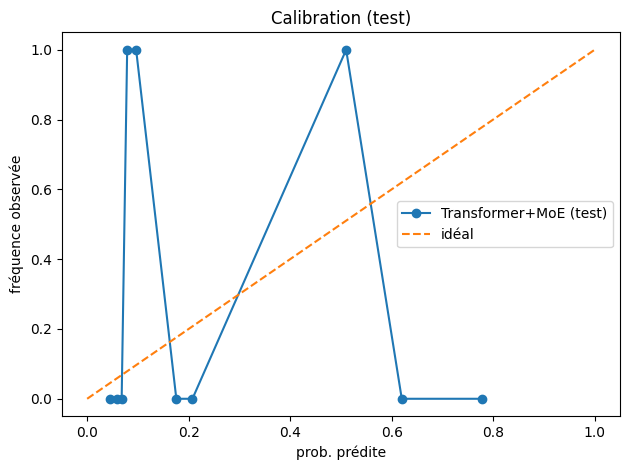

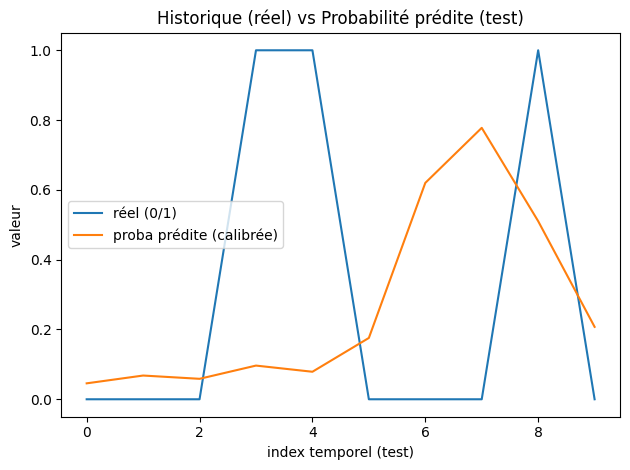

In [372]:

@torch.no_grad()
def logits_on_np(mdl, X):
    z, *_ = mdl(torch.tensor(X, dtype=torch.float32).to(DEVICE))
    return z.detach().cpu().numpy()

# logits
z_tr = logits_on_np(model, Xtrn)
z_va = logits_on_np(model, Xvan)
z_te = logits_on_np(model, Xten)

# fit Platt sur validation
CAL.fit(z_va, yva)

# proba calibrées
p_tr = CAL.transform_logits(z_tr)
p_va = CAL.transform_logits(z_va)
p_te = CAL.transform_logits(z_te)


def report_split(name, y, p):
    p = np.clip(np.asarray(p, dtype=float), 1e-6, 1-1e-6)
    auc = roc_auc_score(y, p) if len(np.unique(y))>1 else float("nan")
    ap  = average_precision_score(y, p) if len(np.unique(y))>1 else float("nan")
    ll  = log_loss(y, p)
    br  = brier_score_loss(y, p)
    acc = accuracy_score(y, (p>=0.5).astype(int))
    print(f"{name:5s}  AUC={auc:.4f}  AP={ap:.4f}  LogLoss={ll:.4f}  Brier={br:.4f}  Acc={acc:.4f}")

for nm, (Y, P) in {"Train":(ytr,p_tr), "Valid":(yva,p_va), "Test":(yte,p_te)}.items():
    report_split(nm, Y, P)

# courbe de calibration (test)
pt, pp = calibration_curve(yte, p_te, n_bins=10, strategy="quantile")
plt.figure(); plt.plot(pp, pt, "o-", label="Transformer+MoE (test)")
plt.plot([0,1],[0,1],"--", label="idéal")
plt.xlabel("prob. prédite"); plt.ylabel("fréquence observée"); plt.title("Calibration (test)")
plt.legend(); plt.tight_layout(); plt.show()

# historique vs proba (test)
plt.figure(); plt.plot(range(len(yte)), yte, label="réel (0/1)")
plt.plot(range(len(yte)), p_te, label="proba prédite (calibrée)")
plt.xlabel("index temporel (test)"); plt.ylabel("valeur")
plt.title("Historique (réel) vs Probabilité prédite (test)")
plt.legend(); plt.tight_layout(); plt.show()

## Attentions & usage des experts (diagnostic)

Diagnostics calculés sur le split: test (N=10)


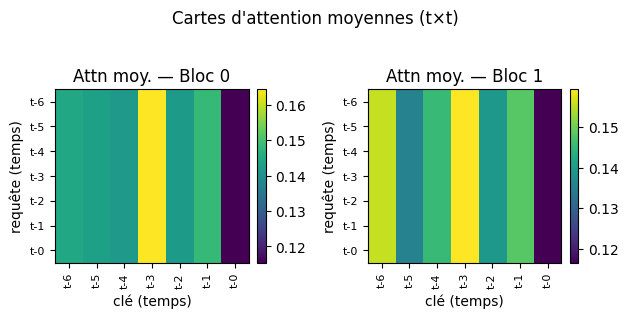

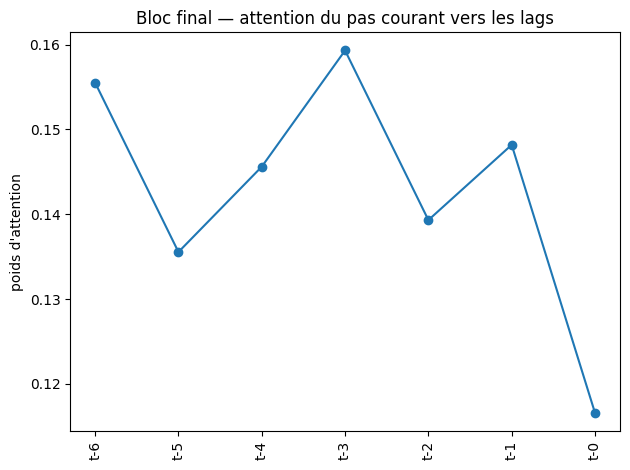

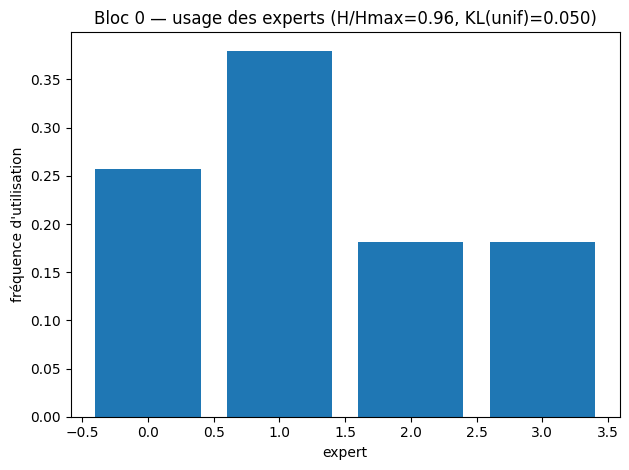

[Bloc 0] usage experts = [0.257 0.38  0.181 0.181] | H=1.336/1.386 (balance=0.96)  KL(unif)=0.050


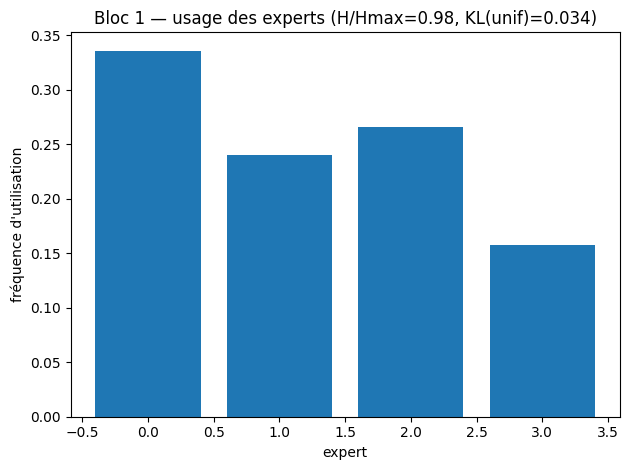

[Bloc 1] usage experts = [0.336 0.241 0.266 0.158] | H=1.353/1.386 (balance=0.98)  KL(unif)=0.034
Températures Gumbel (approx) par bloc: [1.52 1.52]


In [373]:
@torch.no_grad()
def collect_attn_and_usage(model, X, bs=16, device=DEVICE):
    """
    Retourne:
      - attn_avg: liste [depth] de matrices (T,T) attention moyennées (batch & heads)
      - usage_avg: liste [depth] de vecteurs (E,) = répartition d'usage des experts
    """
    model.eval()
    depth = len(model.blocks)
    T = X.shape[1]
    # nombre d'experts (fallback si attribut absent)
    try:
        E = int(model.blocks[0].moe.n_experts)
    except Exception:
        E = int(model.blocks[0].moe.gate.out_features)

    attn_sum = [torch.zeros((T, T), dtype=torch.float32) for _ in range(depth)]
    tok_total = 0  # pour pondérer les usages par (B*T)
    usage_sum = [torch.zeros((E,), dtype=torch.float32) for _ in range(depth)]

    N = len(X)
    for i in range(0, N, bs):
        xb = torch.tensor(X[i:i+bs], dtype=torch.float32, device=device)
        # encode renvoie (h, attn_ws, auxs) ; aux = moyenne sur (B,T) de w_soft
        h, attn_ws, auxs = model.encode(xb)

        # Attentions: w shape = [B, H, T, T] (batch_first=True)
        for b, w in enumerate(attn_ws):
            w = torch.nan_to_num(w, nan=0.0, posinf=0.0, neginf=0.0)
            w_mean = w.mean(dim=1)               # moyenne sur les têtes -> [B, T, T]
            attn_sum[b] += w_mean.mean(dim=0).cpu()  # moyenne batch

        # Usage experts: aux est déjà moyen sur (B,T) -> repondérer par B*T
        wt = xb.size(0) * xb.size(1)
        for b, aux in enumerate(auxs):
            usage_sum[b] += (aux.detach().cpu() * wt)
        tok_total += wt

    attn_avg = [ (A / max(1, (N // bs + (N % bs > 0)))).numpy() for A in attn_sum ]
    usage_avg = [ (U / max(1, tok_total)).numpy() for U in usage_sum ]
    return attn_avg, usage_avg

def pick_split_for_diag():
    if len(Xten) > 0:  return Xten, "test"
    if len(Xvan) > 0:  return Xvan, "val"
    return Xtrn, "train"

Xdiag, split_name = pick_split_for_diag()
print(f"Diagnostics calculés sur le split: {split_name} (N={len(Xdiag)})")

attn_avg, usage_avg = collect_attn_and_usage(model, Xdiag, bs=16, device=DEVICE)

# --- Heatmaps d'attention par bloc ---
depth = len(attn_avg)
cols = depth
plt.figure(figsize=(3.2*cols, 3.2))
for i, A in enumerate(attn_avg):
    plt.subplot(1, cols, i+1)
    plt.imshow(A, aspect="auto")
    plt.title(f"Attn moy. — Bloc {i}")
    plt.xlabel("clé (temps)")
    plt.ylabel("requête (temps)")
    ticks = list(range(WIN))
    lbls = [f"t-{WIN-1-k}" for k in ticks]
    plt.xticks(ticks, lbls, rotation=90, fontsize=8)
    plt.yticks(ticks, lbls, fontsize=8)
    plt.colorbar(fraction=0.046, pad=0.04)
plt.suptitle("Cartes d'attention moyennes (t×t)"); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

# --- Focus: attention du dernier pas (t0) vers les lags (bloc final) ---
A_last = attn_avg[-1]  # [T,T]
# on prend la ligne de la requête "dernier pas" (query t=WIN-1)
lag_weights = A_last[WIN-1, :]  # shape (T,)
plt.figure()
plt.plot(range(WIN), lag_weights, marker="o")
plt.xticks(range(WIN), [f"t-{WIN-1-k}" for k in range(WIN)], rotation=90)
plt.ylabel("poids d'attention")
plt.title("Bloc final — attention du pas courant vers les lags")
plt.tight_layout(); plt.show()

# --- Usage des experts (barres) + entropie/KL ---
def entropy(p):
    p = np.clip(np.asarray(p, dtype=float), 1e-12, 1.0)
    return float(-(p*np.log(p)).sum())

for i, u in enumerate(usage_avg):
    u = np.clip(u, 1e-12, 1.0)
    u = u / u.sum()
    H = entropy(u)
    Hmax = np.log(len(u))
    unif = np.full_like(u, 1.0/len(u))
    KL = float((u*np.log(u/unif)).sum())

    plt.figure(); plt.bar(range(len(u)), u)
    plt.xlabel("expert"); plt.ylabel("fréquence d'utilisation")
    plt.title(f"Bloc {i} — usage des experts (H/Hmax={H/Hmax:.2f}, KL(unif)={KL:.3f})")
    plt.tight_layout(); plt.show()

    print(f"[Bloc {i}] usage experts =", np.round(u, 3),
          f"| H={H:.3f}/{Hmax:.3f} (balance={H/Hmax:.2f})  KL(unif)={KL:.3f}")

# --- (optionnel) température gumbel actuelle par bloc ---
temps = []
for i, blk in enumerate(model.blocks):
    try:
        temps.append(float(blk.moe.temperature()))
    except Exception:
        temps.append(np.nan)
print("Températures Gumbel (approx) par bloc:", np.round(temps, 3))


## Integrated Gradients (global & local)

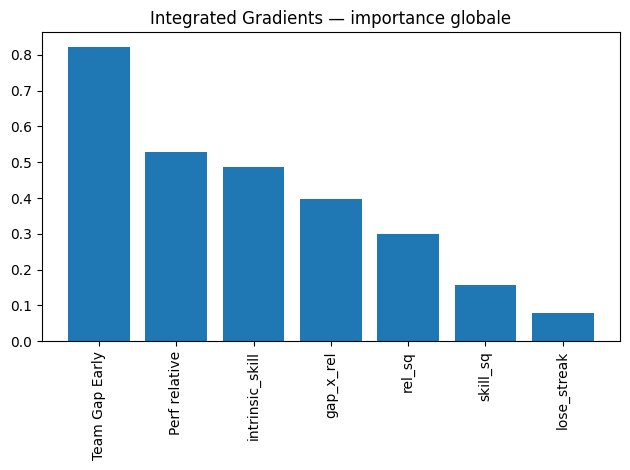

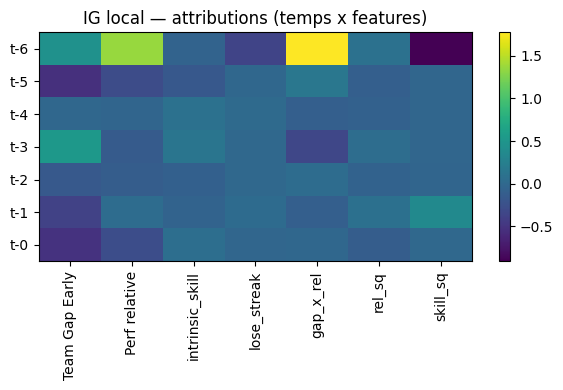

In [374]:

def integrated_gradients(mdl, x, steps=64, baseline=None, use_prob=False):
    mdl.eval()
    x = torch.as_tensor(x, dtype=torch.float32, device=DEVICE)
    if baseline is None:
        baseline = torch.zeros_like(x)
    total = torch.zeros_like(x)
    for k in range(1, steps+1):
        alpha = float(k)/steps
        xk = baseline + alpha*(x - baseline)
        xk.requires_grad_(True)
        logit, *_ = mdl(xk)
        out = torch.sigmoid(logit) if use_prob else logit
        grads = torch.autograd.grad(outputs=out.sum(), inputs=xk, retain_graph=False)[0]
        total = total + grads
        mdl.zero_grad(set_to_none=True)
    attrs = (x - baseline) * total / steps
    return attrs.detach().cpu().numpy()

# Global importance = moyenne des |attributions| sur (temps, batch)
if len(Xten) > 0:
    idx = np.random.RandomState(0).choice(len(Xten), size=min(128,len(Xten)), replace=False)
    A = integrated_gradients(model, Xten[idx], steps=64)  # [B,T,D]
    G = np.mean(np.abs(A), axis=(0,1))
    order = np.argsort(-G)
    plt.figure(); plt.bar(range(len(G)), G[order])
    plt.xticks(range(len(G)), np.array(FEATURES)[order], rotation=90)
    plt.title("Integrated Gradients — importance globale")
    plt.tight_layout(); plt.show()

    # Local heatmap (premier item test)
    L = integrated_gradients(model, Xten[0:1], steps=128)[0]  # [T,D]
    plt.figure(figsize=(6,4)); plt.imshow(L, aspect="auto")
    plt.xticks(range(len(FEATURES)), FEATURES, rotation=90)
    plt.yticks(range(L.shape[0]), [f"t-{L.shape[0]-1-i}" for i in range(L.shape[0])])
    plt.colorbar(); plt.title("IG local — attributions (temps x features)")
    plt.tight_layout(); plt.show()

## LIME (local) & SHAP Kernel (global) — optionnels

In [375]:

def scale_flat_2d(X2D):
    X = np.asarray(X2D, dtype=np.float32).copy()
    for j, sc in enumerate(scalers):
        X[:, j] = sc.transform(X[:, j].reshape(-1,1)).ravel()
    return X

def to_seq_from_flat(X2D):
    X = scale_flat_2d(X2D)
    return np.repeat(X[:, None, :], WIN, axis=1)

@torch.no_grad()
def logits_on_flat_2D(mdl, X2D):
    Xseq = to_seq_from_flat(X2D)
    z, *_ = mdl(torch.from_numpy(Xseq.astype(np.float32)).to(DEVICE))
    return z.detach().cpu().numpy()

def proba_on_flat_2cols(mdl, X2D):
    z = logits_on_flat_2D(mdl, X2D)
    p = CAL.transform_logits(z)
    return np.c_[1.0 - p, p]

def proba1_on_flat(mdl, X2D):
    return proba_on_flat_2cols(mdl, X2D)[:, 1]

# Base 2D pour LIME/SHAP
base2d = df[FEATURES].fillna(0.0).astype(np.float32).reset_index(drop=True)

# LIME
try:
    from lime.lime_tabular import LimeTabularExplainer
    explainer = LimeTabularExplainer(
        training_data=base2d.values,
        feature_names=FEATURES,
        class_names=["lose","win"],
        mode="classification",
        discretize_continuous=True
    )
    i0 = int(min(len(base2d)-1, max(0, len(base2d)//2)))
    x0 = base2d.iloc[i0].values.astype(np.float32)
    exp = explainer.explain_instance(
        data_row=x0,
        predict_fn=lambda X: proba_on_flat_2cols(model, X.astype(np.float32)),
        num_features=min(10, len(FEATURES)),
        top_labels=1
    )
    print("\nLIME — top contribs (win):")
    for name, val in exp.as_list(label=1):
        print(f"{name:24s} {val:+.4f}")
except Exception as e:
    print("LIME indisponible (ok) →", e)

# SHAP Kernel
try:
    import shap
    rng = np.random.RandomState(0)
    bg_idx = rng.choice(len(base2d), size=min(100, len(base2d)), replace=False)
    bg = base2d.iloc[bg_idx].values.astype(np.float32)
    f_shap = lambda X: proba1_on_flat(model, X.astype(np.float32))
    expl = shap.KernelExplainer(f_shap, bg)
    sv = expl.shap_values(x0.reshape(1,-1), nsamples=200)
    pairs = list(zip(FEATURES, sv[0]))
    print("\nSHAP (Kernel) — top |contribs|:")
    for name, val in sorted(pairs, key=lambda t: -abs(float(t[1])))[:10]:
        print(f"{name:24s} {val:+.4f}")
except Exception as e:
    print("SHAP indisponible (ok) →", e)


LIME — top contribs (win):
LIME indisponible (ok) → 1


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


SHAP (Kernel) — top |contribs|:
Perf relative            -0.2164
Team Gap Early           -0.0726
skill_sq                 -0.0586
intrinsic_skill          -0.0511
rel_sq                   -0.0384
gap_x_rel                +0.0143
lose_streak              -0.0110


## PDP & ICE (dernière étape temporelle)

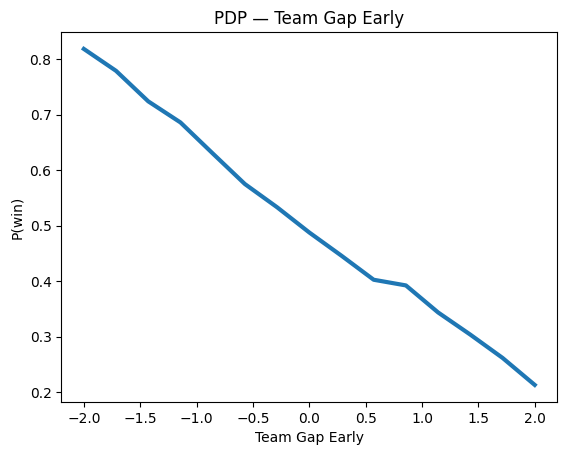

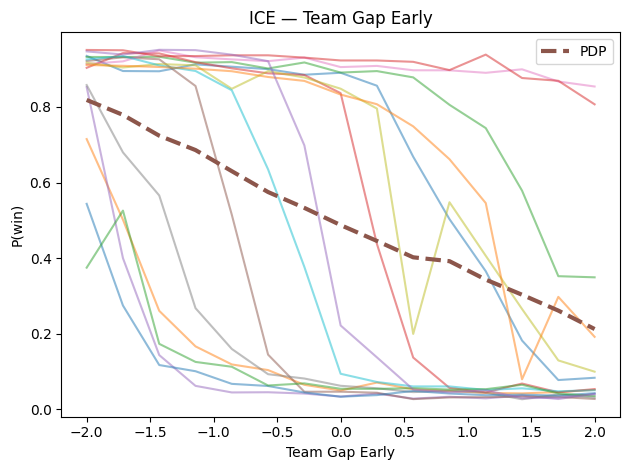

In [376]:

def pdp_1d(base_df, feat_name, grid_vals):
    Xtmp = base_df.copy()
    out = []
    for v in grid_vals:
        Xtmp[feat_name] = v
        X = Xtmp[FEATURES].values.astype(np.float32)
        for j, sc in enumerate(scalers):
            X[:, j] = sc.transform(X[:, j].reshape(-1,1)).ravel()
        Xseq = np.repeat(X[:, None, :], WIN, axis=1)
        z, *_ = model(torch.from_numpy(Xseq).to(DEVICE))
        p = CAL.transform_logits(z.detach().cpu().numpy())
        out.append(p.mean())
    return np.array(out)


def ice_1d(base_df, feat_name, grid_vals, n_curves=15, seed=0):
    rng = np.random.RandomState(seed)
    idx = rng.choice(len(base_df), size=min(n_curves, len(base_df)), replace=False)
    curves = []
    for i in idx:
        row = base_df.iloc[[i]].copy()
        vals = []
        for v in grid_vals:
            row[feat_name] = v
            X = row[FEATURES].values.astype(np.float32)
            for j, sc in enumerate(scalers):
                X[:, j] = sc.transform(X[:, j].reshape(-1,1)).ravel()
            Xseq = np.repeat(X[:, None, :], WIN, axis=1)
            z, *_ = model(torch.from_numpy(Xseq).to(DEVICE))
            p = CAL.transform_logits(z.detach().cpu().numpy())
            vals.append(float(p[0]))
        curves.append(vals)
    return np.array(curves)

if len(base2d) > 0:
    f = gap_col
    q = np.quantile(base2d[f], [0.05, 0.25, 0.5, 0.75, 0.95])
    grid = np.linspace(q[0], q[-1], 15)
    P = pdp_1d(base2d, f, grid)
    C = ice_1d(base2d, f, grid, n_curves=15)
    plt.figure(); plt.plot(grid, P, lw=3); plt.title(f"PDP — {f}"); plt.xlabel(f); plt.ylabel("P(win)")
    plt.figure();
    for k in range(C.shape[0]):
        plt.plot(grid, C[k], alpha=0.5)
    plt.plot(grid, P, lw=3, linestyle="--", label="PDP")
    plt.legend(); plt.title(f"ICE — {f}"); plt.xlabel(f); plt.ylabel("P(win)")
    plt.tight_layout(); plt.show()

## Prédictions historiques vs modèle + 20 prédictions futures exportées

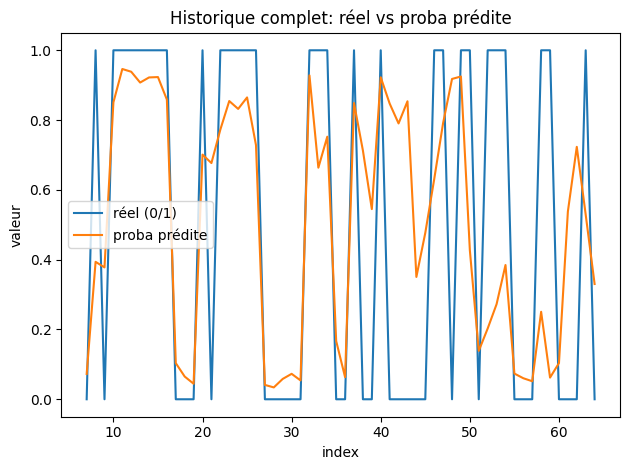

Écrit: future_predictions_transformer_moe_multiflow.csv
 step  pred_win_proba    gap_source  Team Gap Early  Perf relative  intrinsic_skill  lose_streak  gap_x_rel   rel_sq  skill_sq
    1           26.67 c-head+anchor       25.940151      -0.650671         0.177796     0.713007 -16.878503 0.423373  0.031611
    2            2.27        c-head       -1.068895      -1.034385         0.896254    -1.738584   1.105649 1.069952  0.803271
    3            7.42        c-head       -0.052129      -0.486917        -0.031621     0.810852   0.025382 0.237088  0.001000
    4            4.32        c-head       -0.170066      -0.490544         0.192841     0.862677   0.083425 0.240633  0.037188
    5           14.46        c-head       -0.658228      -0.426222         0.003365     1.390097   0.280551 0.181665  0.000011
    6           22.63        c-head       -0.489419      -0.571234         0.085655     1.268306   0.279573 0.326309  0.007337
    7            5.89        c-head       -0.632260    

In [377]:

@torch.no_grad()
def proba_on_seq(mdl, Xseq):
    z, *_ = mdl(torch.tensor(Xseq, dtype=torch.float32).to(DEVICE))
    p = CAL.transform_logits(z.detach().cpu().numpy())
    return np.clip(p, 1e-6, 1-1e-6)


def roll_predict(df_full: pd.DataFrame):
    Z = df_full[FEATURES].fillna(0.0).values.astype(np.float32)
    for j, sc in enumerate(scalers):
        Z[:, j] = sc.transform(Z[:, j].reshape(-1,1)).ravel()
    idxs, reals, probs = [], [], []
    with torch.no_grad():
        for i in range(WIN, len(df_full)):
            Xwin = Z[i-WIN:i][None, ...]
            p = proba_on_seq(model, Xwin)[0]
            probs.append(p)
            reals.append(int(df_full[label_col].iloc[i]))
            idxs.append(i)
    return np.array(idxs), np.array(reals), np.array(probs)

@torch.no_grad()
def inverse_single_featvec(v_scaled, scalers):
    v_scaled = np.asarray(v_scaled, dtype=np.float32)
    out = np.zeros_like(v_scaled)
    for j, sc in enumerate(scalers):
        out[j] = sc.inverse_transform(np.array(v_scaled[j]).reshape(-1,1)).ravel()[0]
    return out

@torch.no_grad()
def simulate_next_k_multiflow(df_full, k=20, anchor_pred_gap_first=True):
    assert len(df_full) >= WIN, "Pas assez d'historique pour une fenêtre WIN."
    win_raw = df_full[FEATURES].tail(WIN).copy().reset_index(drop=True)
    win = win_raw.values.astype(np.float32)
    for j, sc in enumerate(scalers):
        win[:, j] = sc.transform(win[:, j].reshape(-1,1)).ravel()
    scen = []
    gap_j = FEATURES.index(gap_col)
    for step in range(1, k+1):
        Xtmp = torch.from_numpy(win[None, ...]).to(DEVICE)
        logit_a, x_next_b, x_next_c, _, _ = model(Xtmp, use_p_stopgrad=True)
        p = torch.sigmoid(logit_a).item()
        x_next_scaled = x_next_c.squeeze(0).cpu().numpy()
        # ancrage externe uniquement au step 1
        if step == 1 and anchor_pred_gap_first and (PRED_GAP_COL is not None):
            gap_ext = float(df_full.iloc[-1].get(PRED_GAP_COL, np.nan))
            if np.isfinite(gap_ext):
                x_next_scaled[gap_j] = scalers[gap_j].transform(np.array(gap_ext, dtype=np.float32).reshape(-1,1)).ravel()[0]
        # inverse scale lisible
        x_next_raw = inverse_single_featvec(x_next_scaled, scalers)
        # recompute dérivées pour propreté
        row = {f: float(x_next_raw[i]) for i,f in enumerate(FEATURES)}
        row["gap_x_rel"] = row[gap_col]*row[rel_col]
        row["rel_sq"]    = row[rel_col]**2
        row["skill_sq"]  = row["intrinsic_skill"]**2
        win = np.vstack([win[1:], x_next_scaled[None, :]])  # roll
        rec = {"step": step, "pred_win_proba": round(100*p, 2), "gap_source": ("c-head" if not (step==1 and PRED_GAP_COL is not None) else "c-head+anchor")}
        rec.update(row)
        scen.append(rec)
    cols = ["step","pred_win_proba","gap_source"] + FEATURES
    return pd.DataFrame(scen)[cols]

# Backtest complet
_df_all = df[[label_col] + FEATURES + ([PRED_GAP_COL] if PRED_GAP_COL else [])].copy()
idxs, reals, probs = roll_predict(_df_all)
plt.figure(); plt.plot(idxs, reals, label="réel (0/1)"); plt.plot(idxs, probs, label="proba prédite")
plt.xlabel("index"); plt.ylabel("valeur"); plt.title("Historique complet: réel vs proba prédite")
plt.legend(); plt.tight_layout(); plt.show()

# Futures déterministes via Multi‑Flow
scen = simulate_next_k_multiflow(_df_all, k=20, anchor_pred_gap_first=True)
scen_path = "future_predictions_transformer_moe_multiflow.csv"
scen.to_csv(scen_path, index=False)
print("Écrit:", scen_path)
print(scen.head(20).to_string(index=False))